# TorchQuantum for State Preparation Circuit

In [22]:
import torch
import torch.optim as optim

import torchquantum as tq
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchquantum.plugins.qiskit_plugin import tq2qiskit
import random
import numpy as np

In [4]:
class QModel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 2
        self.u3_0 = tq.U3(has_params=True, trainable=True)
        self.u3_1 = tq.U3(has_params=True, trainable=True)
        self.cu3_0 = tq.CU3(has_params=True, trainable=True)
        self.cu3_1 = tq.CU3(has_params=True, trainable=True)
        self.u3_2 = tq.U3(has_params=True, trainable=True)
        self.u3_3 = tq.U3(has_params=True, trainable=True)
    
    def forward(self, q_state: tq.QuantumState):
        # the parameter can either be a tq.QuantumState or tq.QuantumDevice
        q_state.reset_states(1)
        self.u3_0(q_state, wires=0)
        self.u3_1(q_state, wires=1)
        self.cu3_0(q_state, wires=[0, 1])
        self.u3_2(q_state, wires=0)
        self.u3_3(q_state, wires=1)
        self.cu3_1(q_state, wires=[1, 0])
        # forward in quantum layers has no return

In [20]:
def train(target_state, state, model, optimizer, epoch):
    model(state)
    result_state = state.get_states_1d()[0]
    
    # compute the state infidelity
    loss = 1 - torch.dot(result_state, target_state).abs() ** 2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 1:
        print(f"epoch {epoch}, LR : {optimizer.param_groups[0]['lr']}")
        print(f'infidelity (loss) : {loss.item()} , \ntarget state : {list(target_state.detach().cpu().numpy())}, \n' + 
              f'result state : {list(result_state.detach().cpu().numpy())}\n')

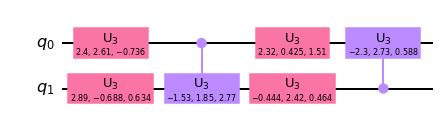

In [56]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
    
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
    
model = QModel()
q_dev = tq.QuantumDevice(n_wires=2)
circ = tq2qiskit(q_dev, model)
circ.draw('mpl')

In [ ]:
n_epochs = 3000
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
    
q_state = tq.QuantumState(n_wires=2)
target_state = torch.tensor([0, 1, 0,  0], dtype=torch.complex64)
for epoch in range(1, n_epochs + 1):
    train(target_state, q_state, model, optimizer, epoch)
    scheduler.step()

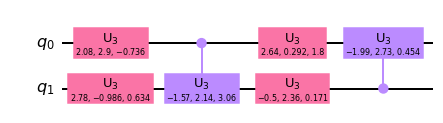

In [42]:
# n_epoch = 30
circ = tq2qiskit(q_dev, model)
circ.draw('mpl')

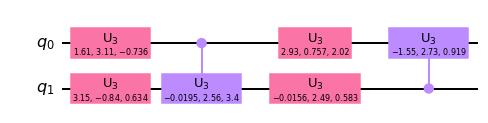

In [39]:
# n_epoch = 300
circ = tq2qiskit(q_dev, model)
circ.draw('mpl')

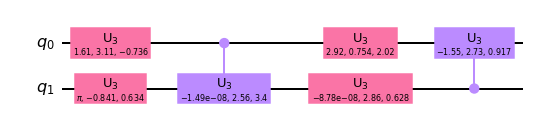

In [36]:
# n_epoch = 3000
circ = tq2qiskit(q_dev, model)
circ.draw('mpl')

In [58]:
q_state = tq.QuantumState(n_wires=2)
print(q_state)
model(q_state)
print(list(q_state.get_states_1d()[0].detach().cpu().numpy()))

QuantumState 2 wires 
 state: tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])
[(1.5456143e-08-1.9961195e-08j), (-0.9554419-0.29517967j), (-1.6603249e-08-1.9604178e-08j), (8.940697e-08+2.9802322e-08j)]
